# Federated Learning

In [3]:
%matplotlib inline

import random
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from knlms import *
from krls import *
from krls_rff import *
from klms import *
from klms_rff import *
from kernel import Kernel

# Multiprocessing
import multiprocessing as mp
print("Number of processors: ", mp.cpu_count())

Number of processors:  8


In [4]:
def generate_data(num_data):
    # AWGN
    v = 0.1*np.random.normal(0,1,num_data+2) 

    # Initial conditions
    d_true =[0.1 , 0.1]
    d = [d_true[0] + v[0], d_true[1] + v[1]]

    # Grab new data
    new_d_true = lambda d: d.append((0.8 - 0.5 * np.exp(-(d[-1]**2)))*d[-1] - (0.3 + 0.9*np.exp(-(d[-1]**2)))*d[-2] + 0.1*np.sin(np.pi*d[-1]))
    for i in range(2,num_data+2):
        new_d_true(d_true)
        d.append(d_true[-1] + v[i])

    u = np.hstack((np.array(d[0:num_data]).reshape(num_data,1),np.array(d[1:num_data+1]).reshape(num_data,1)))
    d_true = d_true[2::]
    d = d[2::]
    return np.array(u), np.array(d),np.array(d_true)

In [5]:
# Parameters
num_data = 3000
kernel = Kernel(3.73)
K = 10 # K edge clients
step_size = 0.09
reg_coeff = 0.03
threshold = 0.5

In [33]:
# Data prepocessing for K clients
edges_u = []
edges_d = []
edges_d_true = []
for k in range(K):
    u,d,d_true = generate_data(num_data)
    
    edges_u.append(np.array(u))
    edges_d.append(np.array(d))
    edges_d_true.append(np.array(d_true))

In [83]:
# Federated learning: Synchronous updating rule

l = 50 # l updates for synchronous
c =  np.ones(K).reshape(K,1)/K # edge weighting, for now, lets try that all data is being received synchronously
D = 100 # Dictionary size
A = 0 # 1 if asynchronous

y = np.zeros(K)
alpha = np.zeros((D,1))
alphas = np.zeros((K,D))

final_mse = []
l_idx = 0
err = np.array([])
# nmse = lambda D_n, Phi_n: np.sum((D_n - Phi_n)**2)
for i in tqdm(range(0,num_data)):
    y_hat = np.zeros(K)
    
    # Local updates
    for k in range(K):
        u_k = edges_u[k][i:i+1]
        d_k = edges_d[k][i:i+1]
        d_true_k = edges_d_true[k][i:i+1]
        if l_idx == 0:
            err,alpha_k,delta = KLMS_RFF(u_k,d_true_k,kernel,step_size,D,alpha_0=alpha)
        else:
            err,alpha_k,delta = KLMS_RFF(u_k,d_true_k,kernel,step_size,D,alpha_0=alphas[k])    
        alphas[k] = alpha_k[0]

        mse += ((np.array(d_true_k) - np.array(d_k) + err)**2)/K

        l_idx+=1
        if l_idx == l:
            break
    final_mse.append(mse[0])
    mse = 0
    if l_idx == l:
        
        # Global update
#         y = A * y + (c @ y_hat.T)
        alpha = (A * alpha) + (alphas.T @ c)
        l_idx = 0

100%|█████████████████████████████████████| 3000/3000 [00:02<00:00, 1279.35it/s]


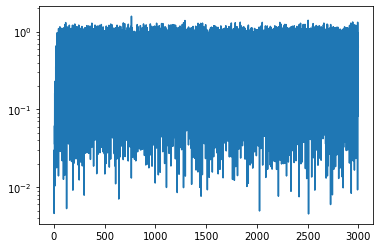

In [86]:
plt.semilogy(range(len(final_mse)),final_mse)

In [38]:
# Federated learning: Asynchronous updating rule

In [12]:
a= np.zeros((3,4))
a[0] = np.array([1,1,1,1])
a

array([[1., 1., 1., 1.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.]])